# Liesel-GAM Demo Notebook

## Setup and Imports

In [ ]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [ ]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

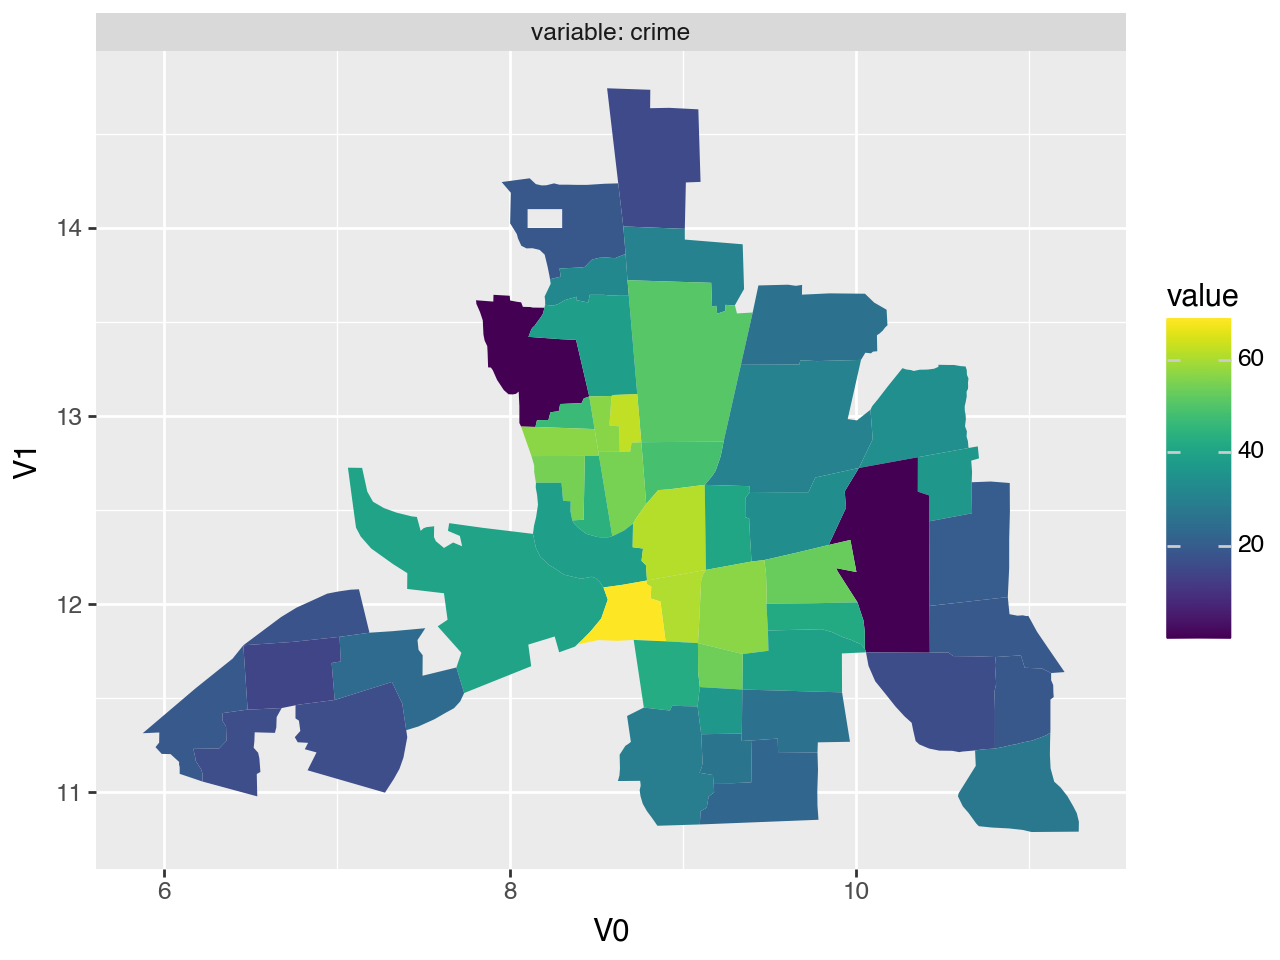

In [20]:
gam.plot_polys(region="district", plot_vars=["crime"], df=columb, polys=polys)

In [21]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y,label
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076,0
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624,1
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719,2
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962,3
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366,4


## Model Definition

### Setup response model

In [22]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [ ]:
loc += tb.fo("area")

# I use scale=1.0 for demo; otherwise there's no nonlinearity
smooth = tb.ps("income", scale=1.0)
loc += tb.vc("area", by=smooth)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


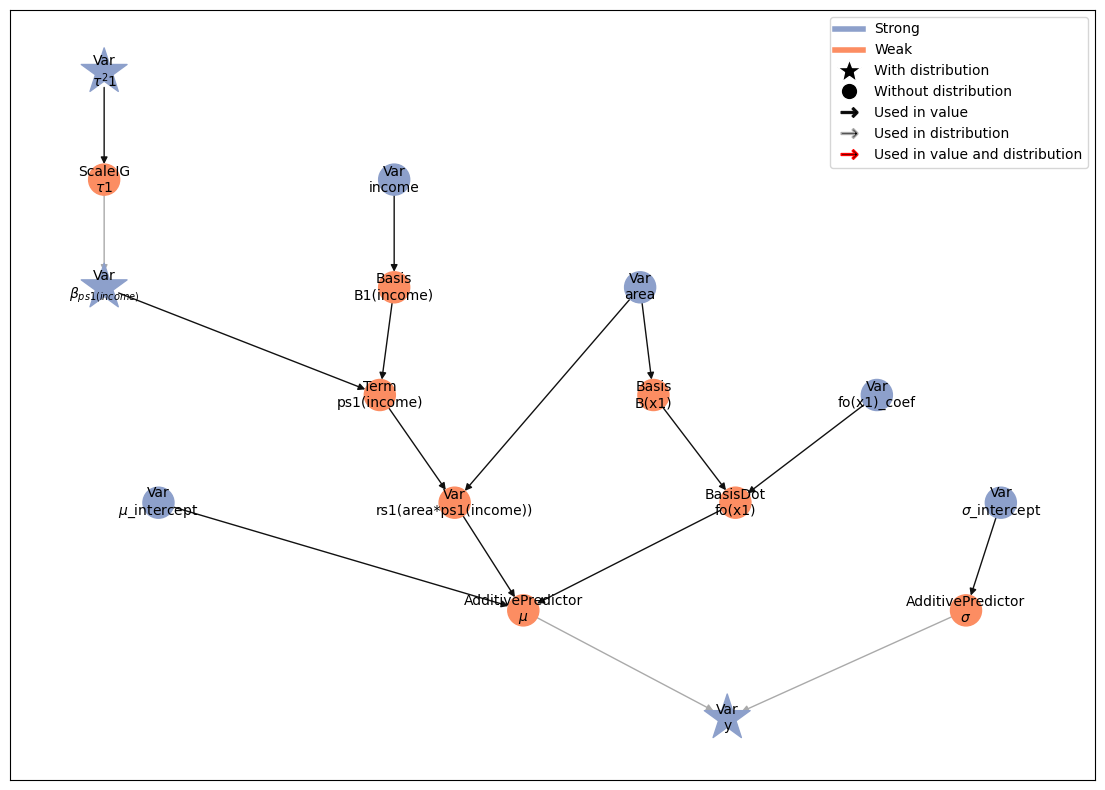

In [24]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [25]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ps1(income)}$', '$\\tau^2$1', 'fo(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.22chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1817.29chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1112.99chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.eng

### MCMC summary

In [26]:
summary = gs.Summary(results)
summary

Parameter summary:

                                kernel       mean         sd     q_0.05  \
parameter             index                                               
$\beta_{ps1(income)}$ (0,)   kernel_02  -0.004996   0.197608  -0.223387   
                      (1,)   kernel_02   0.004895   0.200117  -0.211642   
                      (2,)   kernel_02   0.000045   0.192392  -0.212999   
                      (3,)   kernel_02   0.004316   0.192655  -0.209045   
                      (4,)   kernel_02   0.001219   0.185606  -0.220205   
                      (5,)   kernel_02  -0.004904   0.196491  -0.210141   
                      (6,)   kernel_02  -0.005366   0.207476  -0.225859   
                      (7,)   kernel_02  -0.003345   0.195966  -0.207205   
                      (8,)   kernel_02  -0.001259   0.193819  -0.221082   
                      (9,)   kernel_02   0.001676   0.188637  -0.212808   
                      (10,)  kernel_02   0.009710   0.203414  -0.196283   
                      (11,)  kernel_02  -0.003959   0.183832  -0.218969   
                      (12,)  kernel_02  -0.002479   0.187009  -0.222344   
                      (13,)  kernel_02  -0.003977   0.184848  -0.224312   
                      (14,)  kernel_02  -0.007700   0.195005  -0.245190   
                      (15,)  kernel_02  -0.015119   0.209727  -0.249948   
                      (16,)  kernel_02   0.034152   0.242409  -0.168693   
                      (17,)  kernel_02   0.048066   0.192676  -0.137459   
                      (18,)  kernel_02 -11.201340   2.761632 -15.650682   
$\mu$_intercept       ()     kernel_01  43.021294   3.481935  37.259237   
$\sigma$_intercept    ()     kernel_00   2.605312   0.105196   2.434674   
$\tau^2$1             ()     kernel_03   0.039083   0.208140   0.001667   
fo(x1)_coef           (0,)   kernel_04 -33.835403  15.689822 -59.859038   

                                 q_0.5     q_0.95  sample_size     ess_bulk  \
parameter             index                                                   
$\beta_{ps1(income)}$ (0,)   -0.000682   0.203549         4000  3501.030040   
                      (1,)    0.000783   0.208982         4000  3107.186972   
                      (2,)   -0.000028   0.219859         4000  3659.254475   
                      (3,)    0.000401   0.229651         4000  2967.621856   
                      (4,)    0.000580   0.218130         4000  3813.247236   
                      (5,)   -0.001380   0.192076         4000  3549.185515   
                      (6,)   -0.002109   0.212563         4000  3300.591204   
                      (7,)    0.000771   0.199512         4000  3838.701363   
                      (8,)   -0.000517   0.207014         4000  3005.159328   
                      (9,)    0.000917   0.212029         4000  3666.439666   
                      (10,)   0.002609   0.221556         4000  2970.196225   
                      (11,)  -0.000048   0.212817         4000  3279.676912   
                      (12,)  -0.000756   0.207796         4000  3741.989568   
                      (13,)  -0.001764   0.205455         4000  3628.285516   
                      (14,)  -0.002248   0.203779         4000  3325.531967   
                      (15,)  -0.002118   0.202191         4000  2704.027588   
                      (16,)   0.009466   0.266078         4000  2600.993294   
                      (17,)   0.016215   0.336863         4000  1430.360310   
                      (18,) -11.218891  -6.618897         4000  2931.607587   
$\mu$_intercept       ()     43.011482  48.641295         4000  2721.799644   
$\sigma$_intercept    ()      2.603367   2.782604         4000  3390.965495   
$\tau^2$1             ()      0.007575   0.110409         4000   388.496694   
fo(x1)_coef           (0,)  -33.783758  -8.164993         4000  2595.179249   

                                ess_tail      rhat  
parameter             index                         
$\beta_{ps1(income)}$ 

## Plots

In [27]:
samples = results.get_posterior_samples()

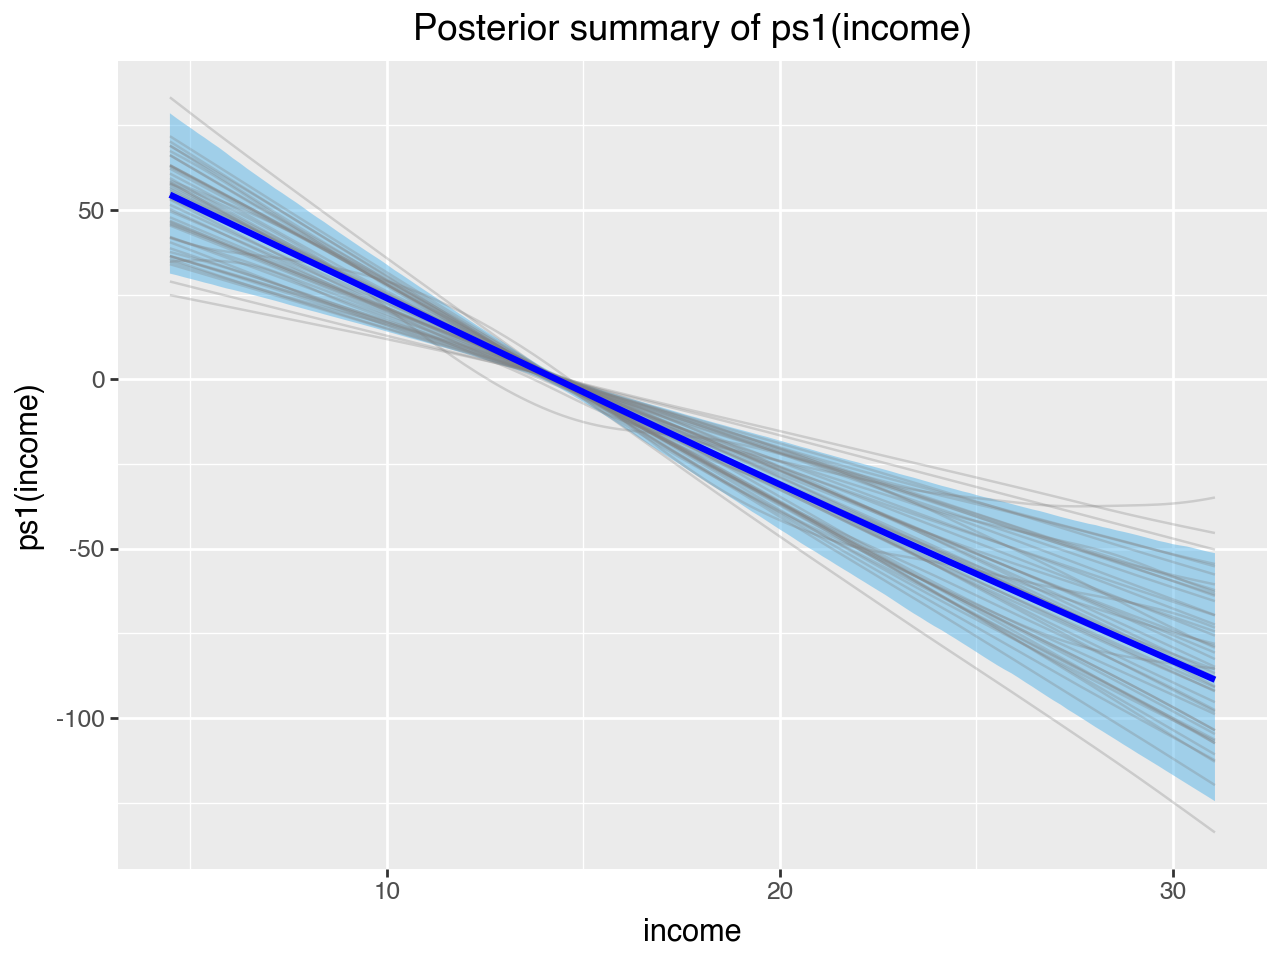

In [28]:
gam.plot_1d_smooth(term=model.vars["ps1(income)"], samples=samples)